In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import sys
import os
sys.path.append('../../acd/acd')
sys.path.append('../../acd/visualization')
sys.path.append('../../acd/acd/util')
sys.path.append('../../acd/acd/scores')
sys.path.append('../../acd/acd/agglomeration')
import viz_1d as viz
import tiling_1d as tiling
import agg_1d as agg
import cd
import score_funcs
sys.path.append('../../acd')
sys.path.append('../../acd/dsets/sst')
from dsets.sst import dset
from dsets.sst.model import LSTMSentiment

# check out how two models differ
import torch.optim as O
import torch.nn as nn

from torchtext import data
from torchtext import datasets
from os.path import join

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

vector_cache = os.path.join(os.getcwd(), '../data/.vector_cache/input_vectors.pt')
word_vectors ='glove.6B.300d'
batch_size=  50


device = 'cuda' if torch.cuda.is_available() else 'cpu'
# form class to hold data
def makedirs(name):
    """helper function for python 2 and 3 to call os.makedirs()
       avoiding an error if the directory to be created already exists"""

    import os, errno

    try:
        os.makedirs(name)
    except OSError as ex:
        if ex.errno == errno.EEXIST and os.path.isdir(name):
            # ignore existing directory
            pass
        else:
            # a different error happened
            raise



In [3]:
inputs = data.Field(lower= True)
answers = data.Field(sequential=False, unk_token=None)

train, dev, test = datasets.SST.splits(inputs, answers, fine_grained=False, train_subtrees=True,
                                       filter_pred=lambda ex: ex.label != 'neutral')

In [4]:
inputs.build_vocab(train, dev, test)
if word_vectors:
    if os.path.isfile(vector_cache):
        inputs.vocab.vectors = torch.load(vector_cache)
    else:
        inputs.vocab.load_vectors(word_vectors)
        makedirs(os.path.dirname(vector_cache))
        torch.save(inputs.vocab.vectors,vector_cache)
answers.build_vocab(train)

train_iter, dev_iter, test_iter = data.BucketIterator.splits(
    (train, dev, test), batch_size=batch_size, device=torch.device(0))

In [44]:

model1 = torch.load('../../acd/dsets/sst/model2.pt', map_location=torch.device(0))
model_path = "../../acd/dsets/sst/results/vanilla"
model_list = os.listdir(model_path)
# model2 = torch.load(join(model_path, model_list[1]), map_location=torch.device(0))
model2 = torch.load('../../acd/dsets/sst/model1.pt', map_location=torch.device(0))

In [45]:
num_batches = 18


In [46]:
model1.eval()
model2.eval()
torch.no_grad()

In [47]:
len(dev)

872

In [48]:
# Model 1
dev_iter.init_epoch()
# check out how two models differ
import torch.optim as O
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
n_dev_correct, dev_loss = 0, 0
cur_idx = 0
for dev_batch_idx, dev_batch in enumerate(dev_iter):
    
    

    answer1 = model1(dev_batch)
    answer2  = model2(dev_batch)
    
    
    cur_idx+=dev_batch.label.shape[0]
    n_dev_correct += (((torch.max(answer1, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data))).sum()
    dev_loss = criterion(answer1, dev_batch.label)
dev_acc = 100. * n_dev_correct / len(dev)
print(dev_acc.item(), dev_loss.item())

83 0.30571115016937256


In [49]:
# Model 2
dev_iter.init_epoch()
# check out how two models differ
import torch.optim as O
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
n_dev_correct, dev_loss = 0, 0
cur_idx = 0
for dev_batch_idx, dev_batch in enumerate(dev_iter):
    
    

    answer1 = model2(dev_batch)
    
    
    cur_idx+=dev_batch.label.shape[0]
    n_dev_correct += (((torch.max(answer1, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data))).sum()
    dev_loss = criterion(answer1, dev_batch.label)
dev_acc = 100. * n_dev_correct / len(dev)
print(dev_acc.item(), dev_loss.item())

83 0.2822088897228241


# Union accuracy

In [50]:
# Model 1
dev_iter.init_epoch()
# check out how two models differ
import torch.optim as O
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
n_dev_correct, dev_loss = 0, 0
cur_idx = 0
for dev_batch_idx, dev_batch in enumerate(dev_iter):
    
    

    answer1 = model1(dev_batch)
    answer2  = model2(dev_batch)
    
    
    cur_idx+=dev_batch.label.shape[0]
    n_dev_correct += (((torch.max(answer1, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data)+
    (torch.max(answer2, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data))>=1).sum()
    dev_loss = criterion(answer1, dev_batch.label)
dev_acc = 100. * n_dev_correct / len(dev)
print(dev_acc.item())

87


# Check alignment


In [51]:
num_batches = 17
is_correct = np.zeros((2,(num_batches)*batch_size))
correct_label =np.zeros_like(is_correct[0])

In [52]:
is_correct[0].shape

(850,)

In [53]:
correct_label.shape

(850,)

In [54]:
dev_batch.label

tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')

In [55]:
with torch.no_grad():
    # check out how two models differ
    dev_iter.init_epoch()
    import torch.optim as O
    import torch.nn as nn
    criterion = nn.CrossEntropyLoss()
    n_dev_correct, dev_loss = 0, 0
    cur_idx = 0
    for dev_batch_idx, dev_batch in enumerate(dev_iter):

        if dev_batch_idx >num_batches-1:
            break
        answer1 = nn.functional.softmax(model1(dev_batch))
        answer2  = nn.functional.softmax(model2(dev_batch))
        is_correct[0, cur_idx:cur_idx + dev_batch.label.shape[0]] = answer1[:,0].cpu().numpy() #(torch.max(answer1, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data).cpu().numpy()
        is_correct[1, cur_idx:cur_idx + dev_batch.label.shape[0]] =  answer2[:,0].cpu().numpy()#(torch.max(answer2, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data).cpu().numpy()
        correct_label[cur_idx:cur_idx + dev_batch.label.shape[0]] =dev_batch.label.cpu().numpy()
        cur_idx+=dev_batch.label.shape[0]
        n_dev_correct += (((torch.max(answer1, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data)+
        (torch.max(answer2, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data))>=1).sum()
        dev_loss = criterion(answer1, dev_batch.label)
    dev_acc = 100. * n_dev_correct / len(dev)

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


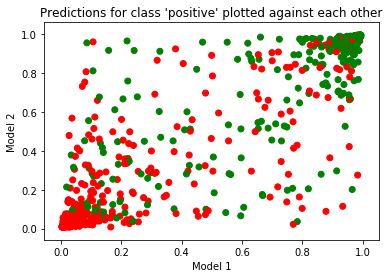

In [56]:
plt.scatter(is_correct[0], is_correct[1],c =   ['r'  if x==1 else 'g' for x in correct_label])
plt.title("Predictions for class 'positive' plotted against each other")
#plt.savefig("Plot_train_set")
plt.ylabel("Model 2");
plt.xlabel("Model 1");